# Riproduzione Data Preparation

Importo le librerie necessarie: 
- Pandas per la manipolazione dei dataframe
- Numpy per strumenti di utilità generale a livello matematico e di strutture dati 
- OS per la navigazione all'interno del *filesystem*

In [1]:
import pandas as pd 
import numpy as np 

#Dichiaro il path della cartella del dataset
import os
dataset_folder = "/home/aliquodfahriam/tinyML/CMAPSS/CMAPSS"

Il dataset non si presenta in forma di CSV ma in formato *.txt*, di seguito procedo a generare i nomi per le colonne. 
Partendo dai sensori che vanno da 1 a 22

In [2]:
#Genero i nomi per le colonne dei sensori
sensors = []
for i in range(1,23):   
    sensor = "sensor"+str(i)
    sensors.append(sensor)

print(sensors)

del i, sensor

['sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21', 'sensor22']


Dato che abbiamo 4 file separati che compongono il dataset di training decido di gestirli utilizzando una lista di dataframe. 

In [3]:
train = []
#test = []
names_train = ['train1', 'train2', 'train3', 'train4']
#names_test = ['test1', 'test2', 'test3', 'test4']

files = os.listdir(dataset_folder)
train_files = [file for file in files if file.startswith('train')]
#test_files = [file for file in files if file.startswith('test')]
# print(train_files)
# print(test_files)
train_files.sort()
#test_files.sort()
print(train_files)
#print(test_files)


#Creo una lista con i nomi delle colonne che non sono sensori
colnames = ["unit_number", "time_cycle", "op_setting1", "op_setting2", "op_setting3"]

for sensor in sensors:
    colnames.append(sensor)


for file in train_files: 
    df = pd.read_csv(dataset_folder+"/"+file, delimiter=' ', index_col=False, names=colnames)
    train.append(df)

df = train[0]

print(colnames)

#df = pd.read_csv(dataset_folder+"/"+train_files[3], delimiter=' ', index_col=False, names=colnames)


['train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']
['test_FD001.txt', 'test_FD002.txt', 'test_FD003.txt', 'test_FD004.txt']
['unit_number', 'time_cycle', 'op_setting1', 'op_setting2', 'op_setting3', 'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21', 'sensor22']


Procedo a rimuovere tutti i valori NaN all'interno dei dataframe e le colonne nulle se presenti

In [4]:
## Proviamo a rimuovere gli NaN dai vari dataframe per capire se c'è qualche valore fuori posto in qualche riga.

for df in train: 
    df = df.fillna(value=0, inplace=True)

df = train[0]

counter = 0
for df in train:
    counter += 1 
    value = (df['sensor22'] != 0).any()
    if value: 
        print("Ci sono valori diversi da zero nel dataframe di posto "+ str(counter))
    else:
        print("Tutti i valori sono zero nel dataframe di posto "+str(counter))

#Comprendo da questo che posso procedere a rimuovere la colonna sensor22 da tutti i dataframe in train: 
for df in train: 
    df.drop('sensor22', axis=1, inplace=True)

df = train[0]

Tutti i valori sono zero nel dataframe di posto 1
Tutti i valori sono zero nel dataframe di posto 2
Tutti i valori sono zero nel dataframe di posto 3
Tutti i valori sono zero nel dataframe di posto 4


###### Sensori con valori costanti
Nel paper in esame viene fatto notare come alcuni sensori riportino valori costanti e quindi siano inutili ai fini del nostro esame. Procediamo a verificare che ciò è vero e capiamo se è corretto eliminarli o meno

I sensori da controllare sono: 
- Numero 1
- Numero 5 
- Numero 10 
- Numero 15 
- Numero 18 
- Numero 19 


Da una prima osservazione si nota come non sia possibile tracciare un modello comune per tutti i dataset di training e si debba quindi ricorrere a una preparazione dei dati più *raffinata* che tenga conto del numero di valori per ogni colonna contenente valori appartenenti ad ogni sensore. 

In [5]:
# df = train[0]
# df1 = train[1]
# df2 = train[2]
# df3 = train[3]

Siamo adesso sicuri di poter rimuovere il sensore numero 22

In [6]:
sensors.remove("sensor22")
unique_values_list = []

for dataframe in train: 
    unique_values_per_df = [] 
    
    for sensor in sensors:
       
        unique_values_frame = dataframe[sensor].unique()
        unique_values_per_df.append(unique_values_frame)
    
    unique_values_list.append(unique_values_per_df)

La variabile *unique_values_list* è composta da 4 righe, in cui ciascuna contine i valori unici di ogni dataframe. Si potrebbe quindi pensare di separare i 4 array per ottenere singolarmente i valori unici di ogni pezzo del dataset. 

Ricordiamo che questo processo è necessario per comprendere se ciò che viene affermato all'interno del paper corrisponde a verità o meno. 

Il passo successivo sarà la normalizzazione dei dataframe tramite un operatore di MinMax Normalization

In [7]:
#Attenzione! Ogni riga corrisponde ai valori unici di un sensore 
#i valori posti ad NaN sono una normale conseguenza del processo che abbiamo seguito
unique_1 = unique_values_list[0]
unique_2 = unique_values_list[1]
unique_3 = unique_values_list[2]
unique_4 = unique_values_list[3]

Si può notare subito come i pattern che riguardano il primo e il terzo dataset siano collegati al fatto che essi rappresentino una singola condizione delle sei possibili, mentre il secondo e il quarto dataset (essendo misti) risultino più complessi da analizzare e, di conseguenza, non ci permettono di essere sicuri nel rimuovere i sensori che abbiamo trovato. 
Per completezza allego le condizioni possibili: 


There are 6 conditions (or combinations) which the 3 operational settings can take.
- Condition 1: Altitude = 0, Mach Number = 0, TRA = 100
- Condition 2: Altitude = 10, Mach Number = 0.25, TRA = 100
- Condition 3: Altitude = 20, Mach Number = 0.7 TRA = 100
- Condition 4: Altitude = 25, Mach Number = 0.62, TRA = 60
- Condition 5: Altitude = 35 Mach Number = 0.84, TRA = 100
- Condition 6: Altitude = 42, Mach Number = 0.84, TRA = 100

Il pattern definito all'interno del paper sembra essere valido per i dataframe 0 e 2 (ovvero FD0001 e FD0003), tuttavia non lo è per i rimanenti due, di conseguenza risulta neessario sottolineare che <mark>da qui in poi supporremo che sia corretto eliminare le colonne dei sensori sopracitati e procederemo serenamente con la loro eliminazione</mark>


Prima di procedere assegnamo ad ogni riga del dataset di train il corretto valore di RUL. 
Dato che le *run* dei file di train rispecchiano la vita intera del motore, possiamo affermare che ad ogni riga il valore di RUL diminuisca di 1 e che il numero di righe che appartengono allo stesso motore, ovvero con lo stesso *unit number*, sia il valore di RUL 

In [9]:
## Inseriamo la colonna RUL all'interno del dataset di train
def insertRULtrain(train_list):
    for df in train:
        #La prossim riga crea un dizionario chiamato cycles che itera per ogni "unique"
        #unit_number all'interno del dataframe e inserisce come valore il massimo dei valori
        #della colonna time_cycle
        cycles = {id_max: df[df['unit_number']==id_max]['time_cycle'].max() for id_max in df['unit_number'].unique()} 

        #la variabile ruls è una lista che contiene la colonna RUL, ovvero i valori in ordine decrescente all'interno della colonna 
        #time_cycle (a intervalli di 1, questo valore potrebbe essere modificato a piacimento modificando leggermente la funzione)
        ruls = [cycles[row[0]] - 1 if row[1] < 1 else cycles[row[0]] - row[1] for row in df.values]

        ##In versione estesa sarebbe
        # ruls = []

        # for row in df.values: 
        #     if row[1] < 1: 
        #         ruls.append(cycles[row[0]] - 1)
        #     else: 
        #         ruls.append(cycles[row[0]] - row[1])
        
        df['RUL'] = ruls

insertRULtrain(train)

Importo la libreria **matplotlib** e **seaborn** per il plot dei grafici utili alla comprensione dei dati

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns 

Ciò che abbiamo detto in precedenza risulta particolarmente chiaro se osserviamo la differenza che intercorre tra i valori dei sensori di FD0001 e FD0002

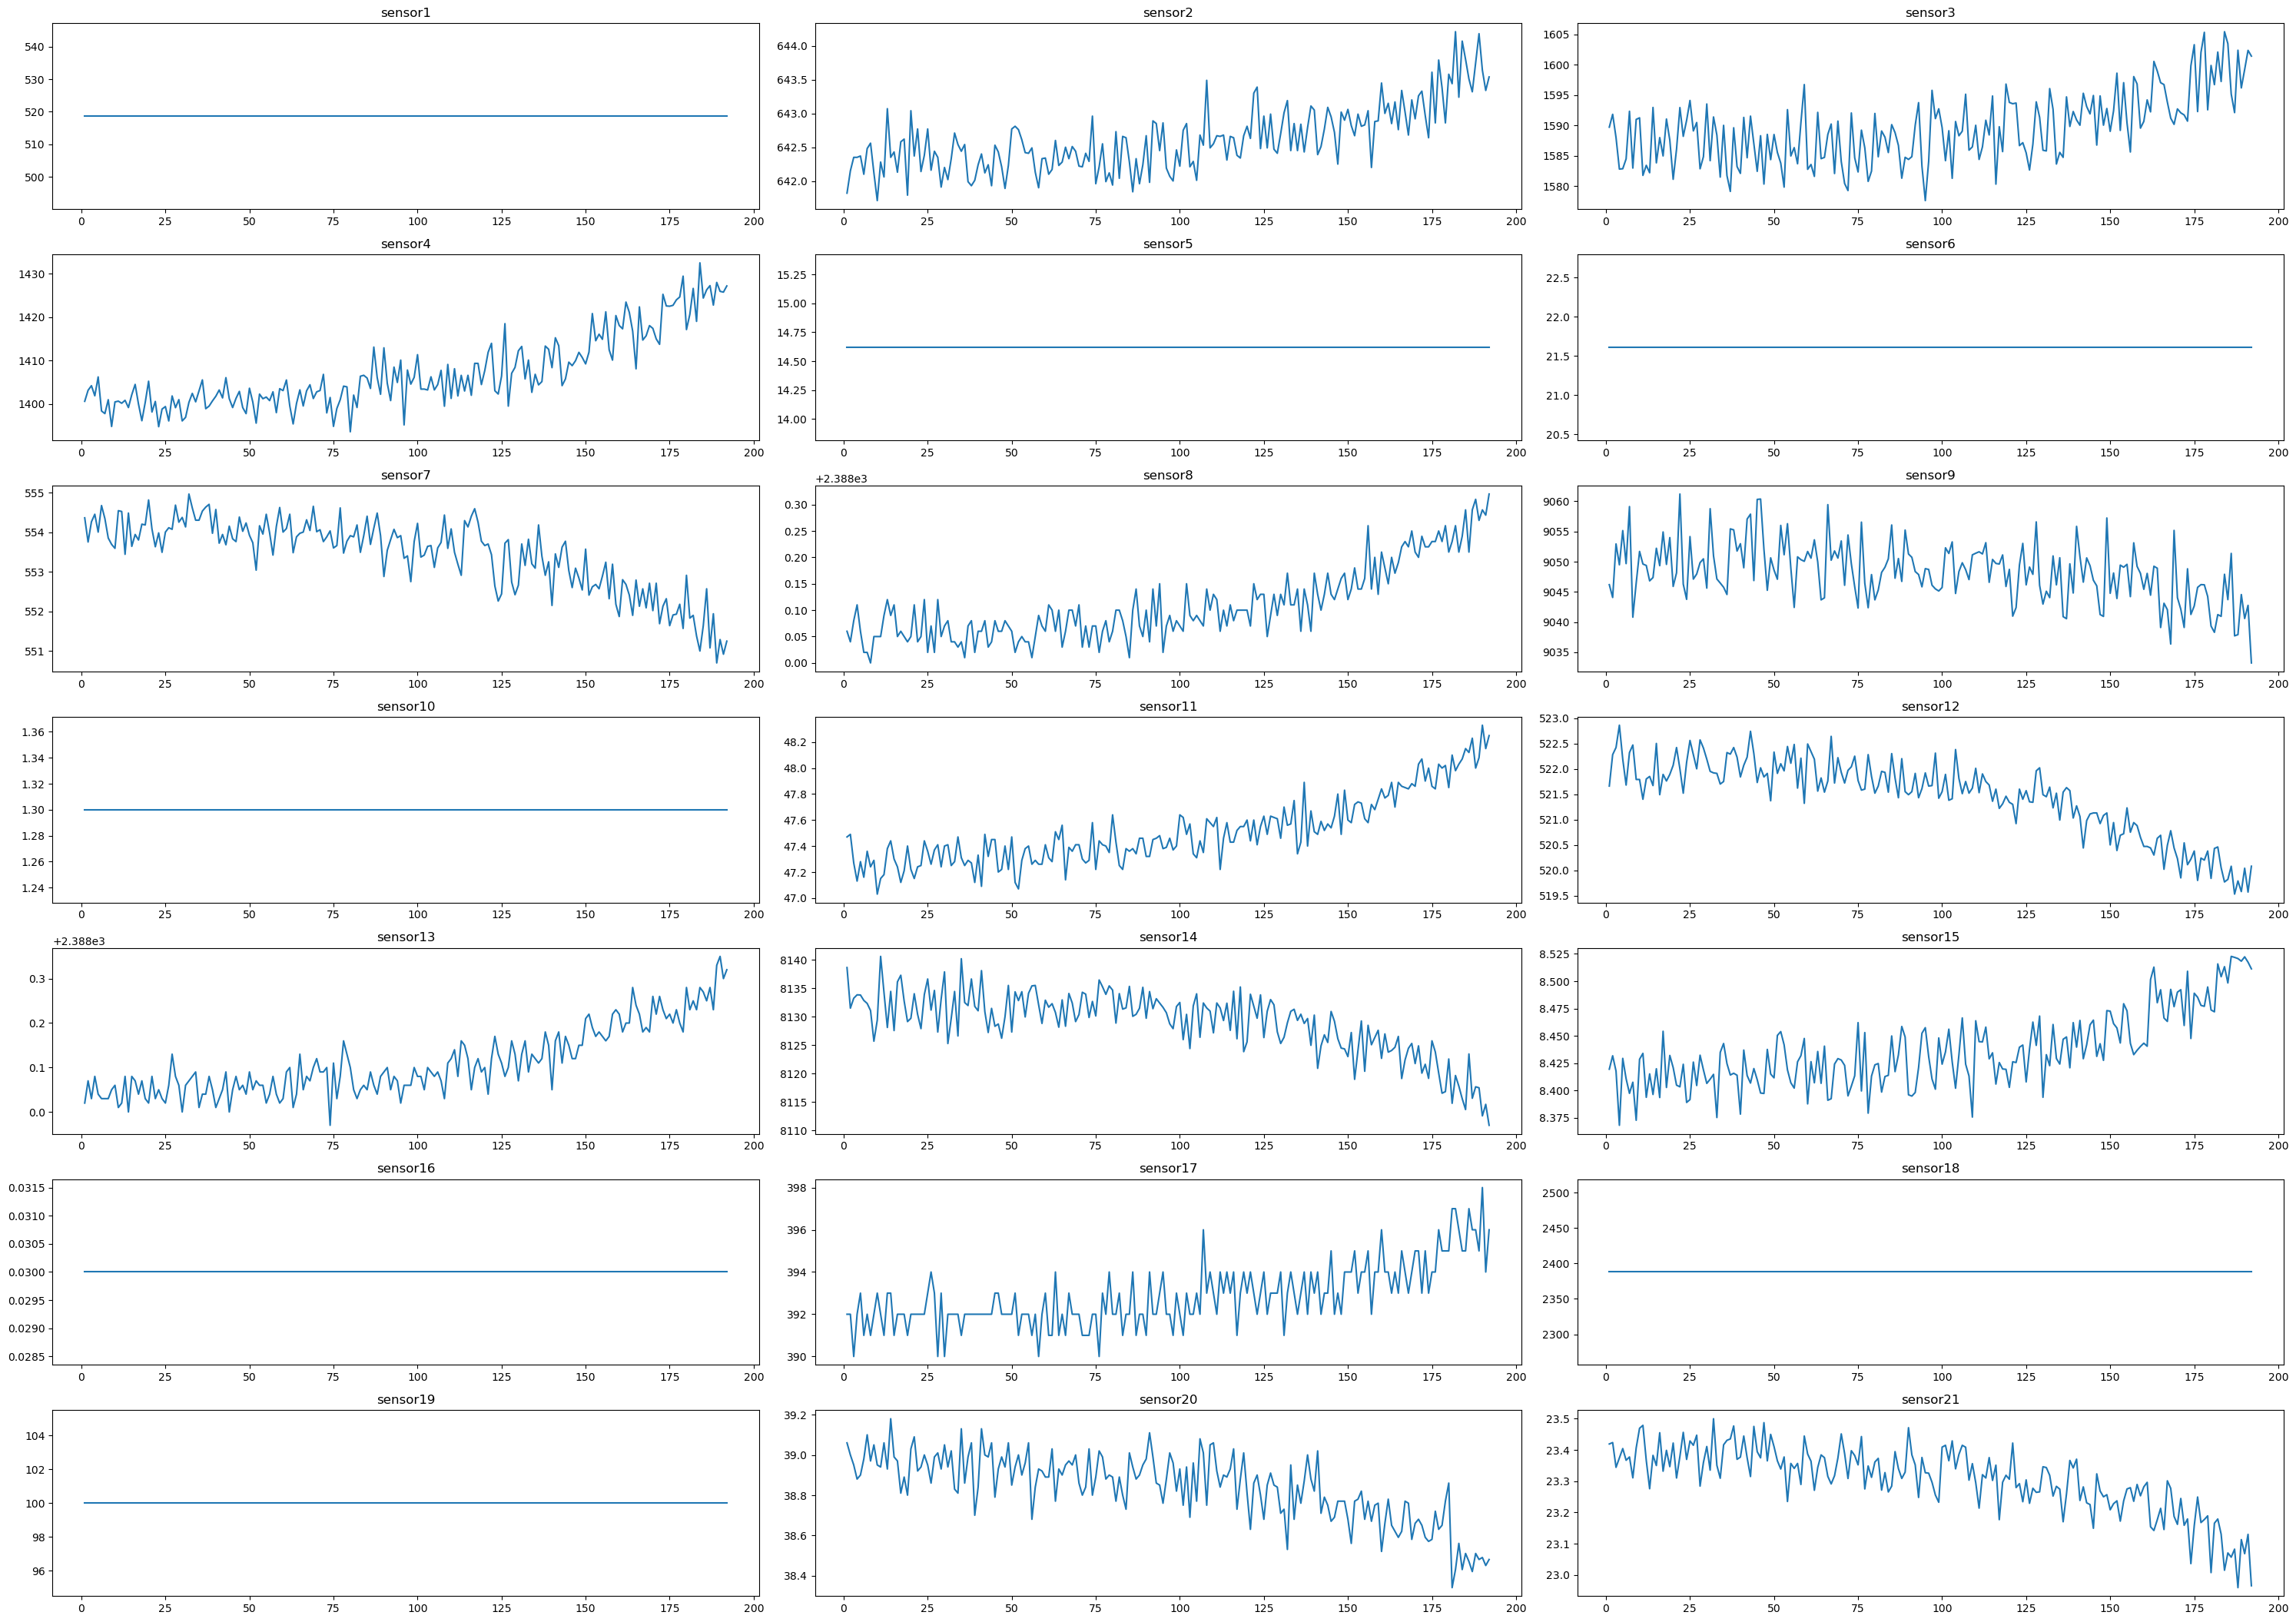

In [11]:
def plotSensors(train_list, numeroDF,unit_number, sensors): 
    #Controllo input banale
    if numeroDF < 0 or numeroDF > 3:
        print("numeroDF può andare da 0 a 3")
        return
   
   
    df = train_list[numeroDF]
    plt.figure(figsize=(30,30))
    i = 0
    for sensor in sensors: 
        plt.subplot(10, 3, i+1).set_title(sensor)
        #Il problema sta nel cercare di plottare i dati dei sensori di un unico ciclo
        sensordata = df[df['unit_number'] == unit_number]
        plt.plot(sensordata['time_cycle'],sensordata[sensor])
        i += 1
    plt.tight_layout()


#numeroDF può andare da 0 a 3 
plotSensors(train, 0, 1,sensors)

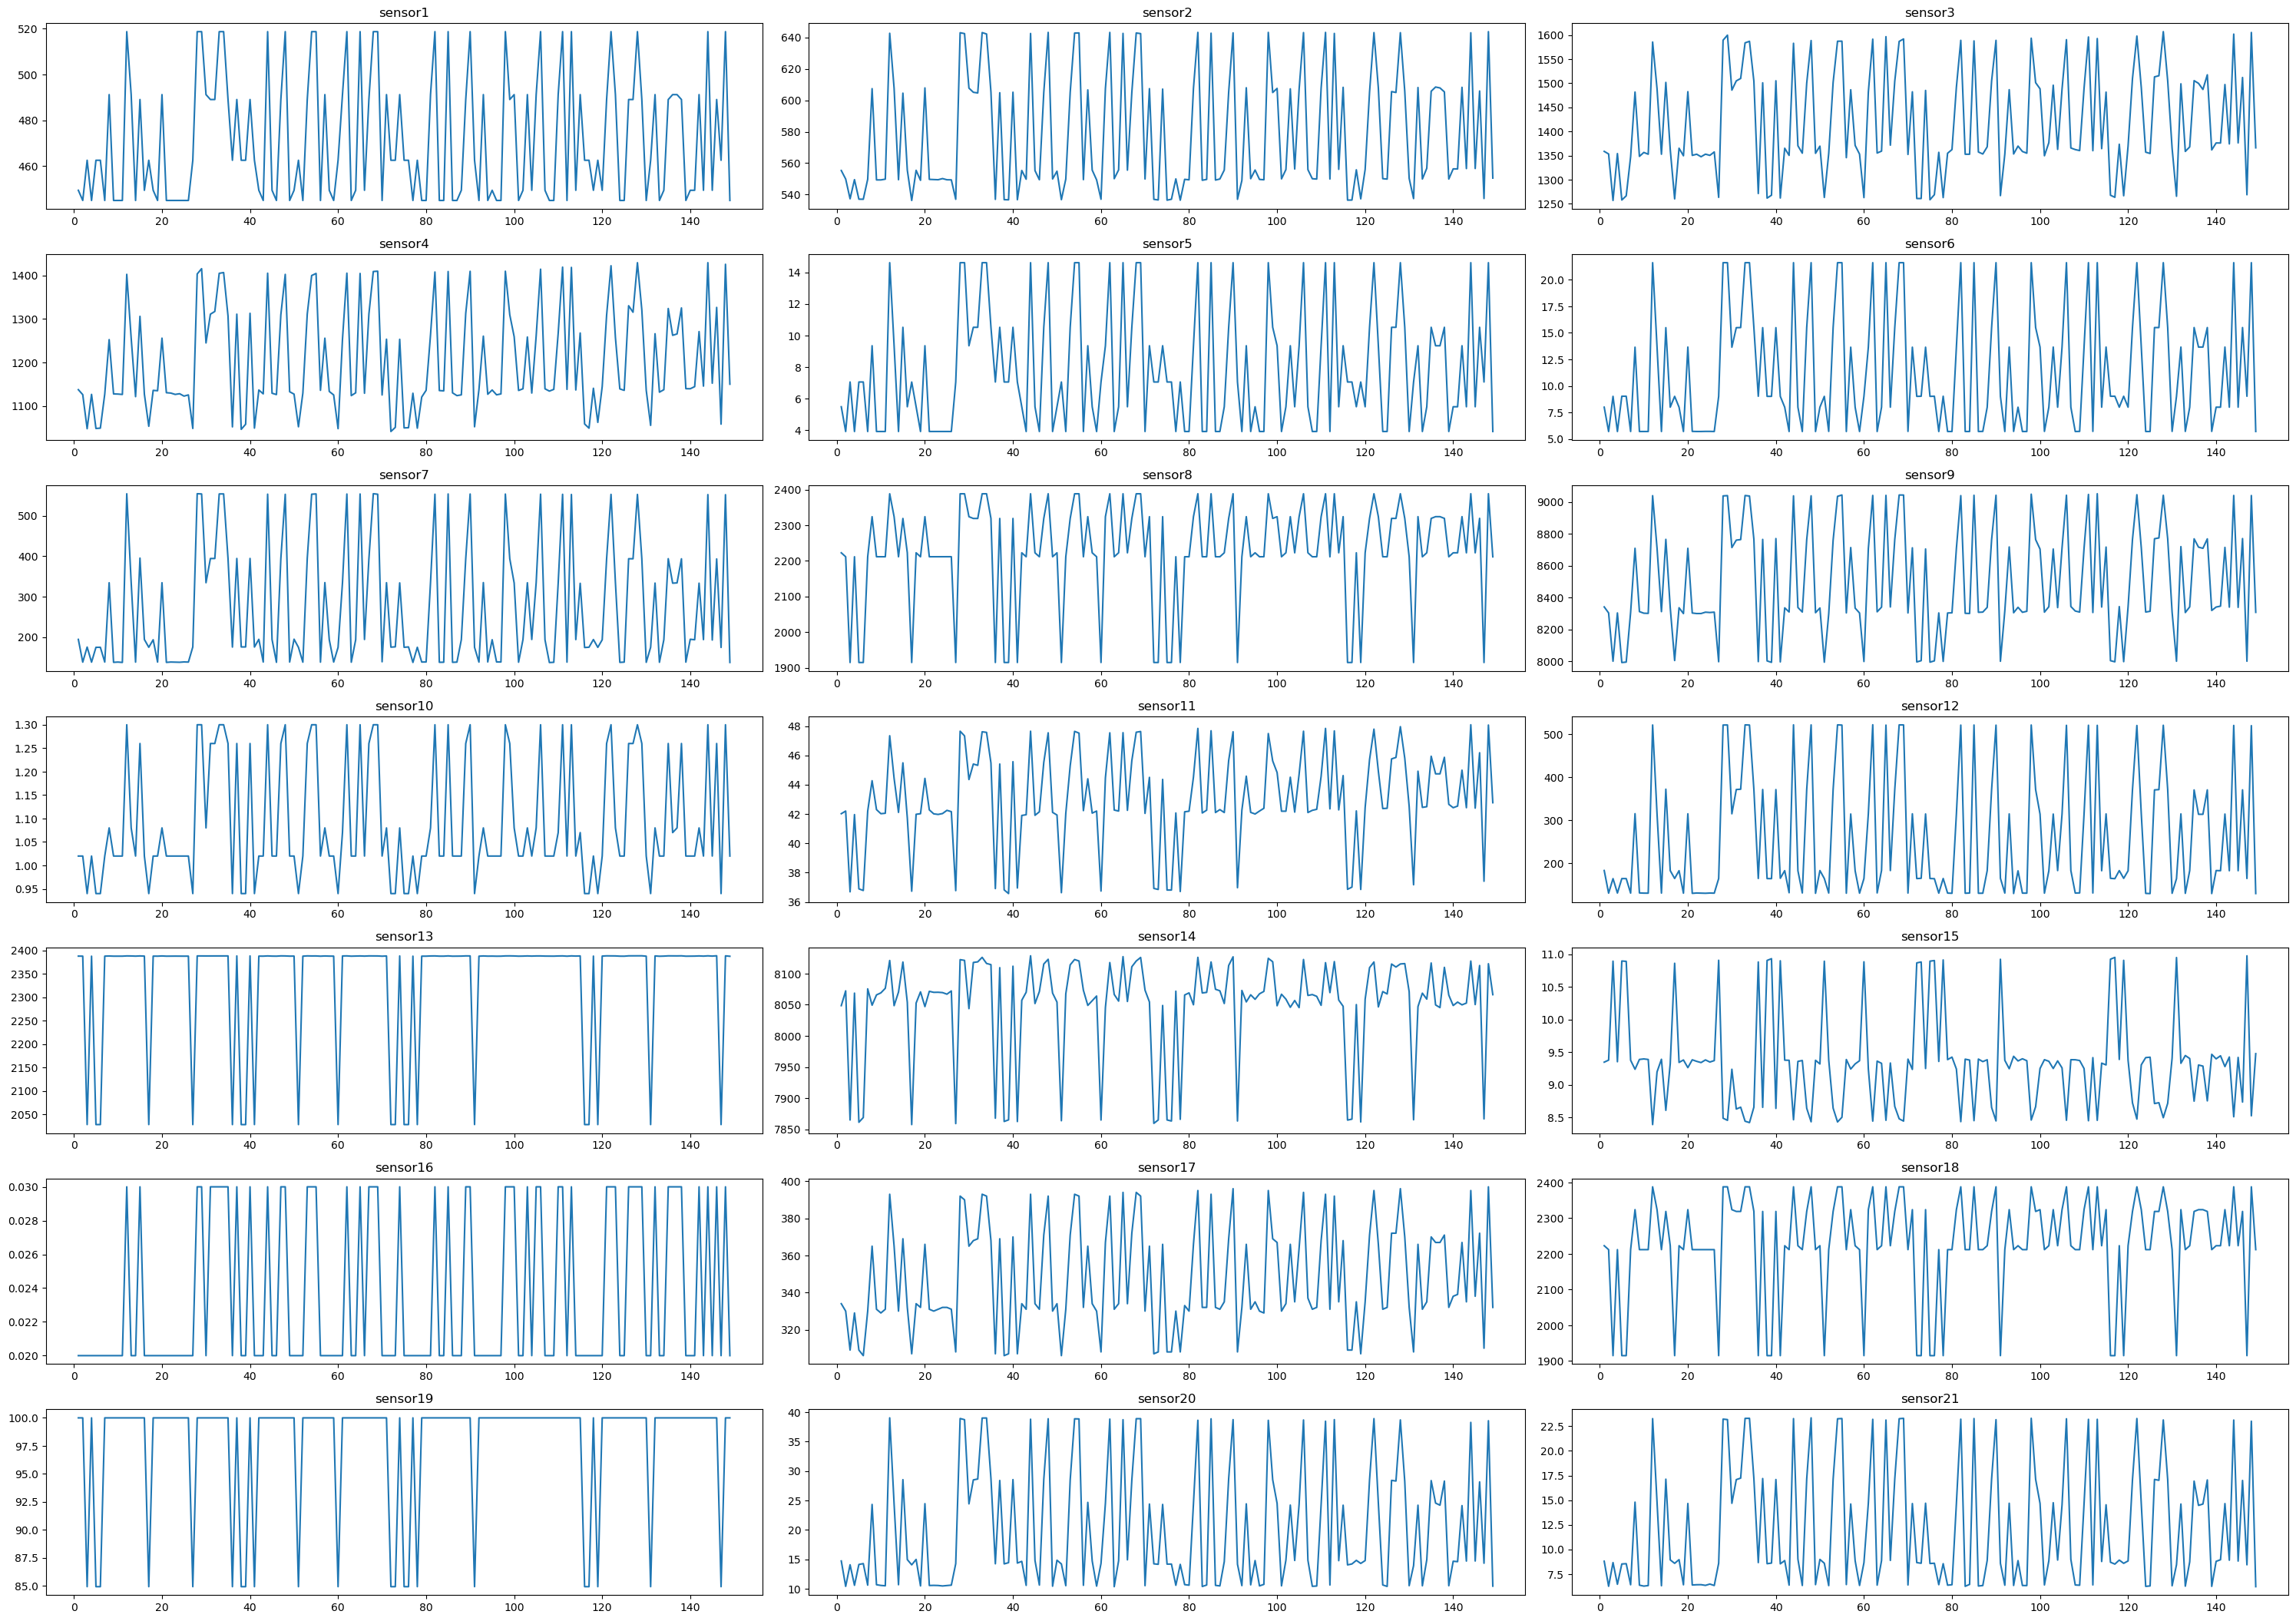

In [12]:
plotSensors(train, 1, 1,sensors)

Dai grafici precedenti è possibile comprendere la profonda differenza tra le mixed contions e le constant conditions

Passiamo a stampare la distribuzione dei dati per ogni sensore e poi confrontiamo il risultato con quello che otterremo post normalizzazione. 

Lasciamo di seguito il <a href = "https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751">Link</a> alla guida per l'utilizzo di **histplot** e a come renderlo simile al deprecato *distplot*. 

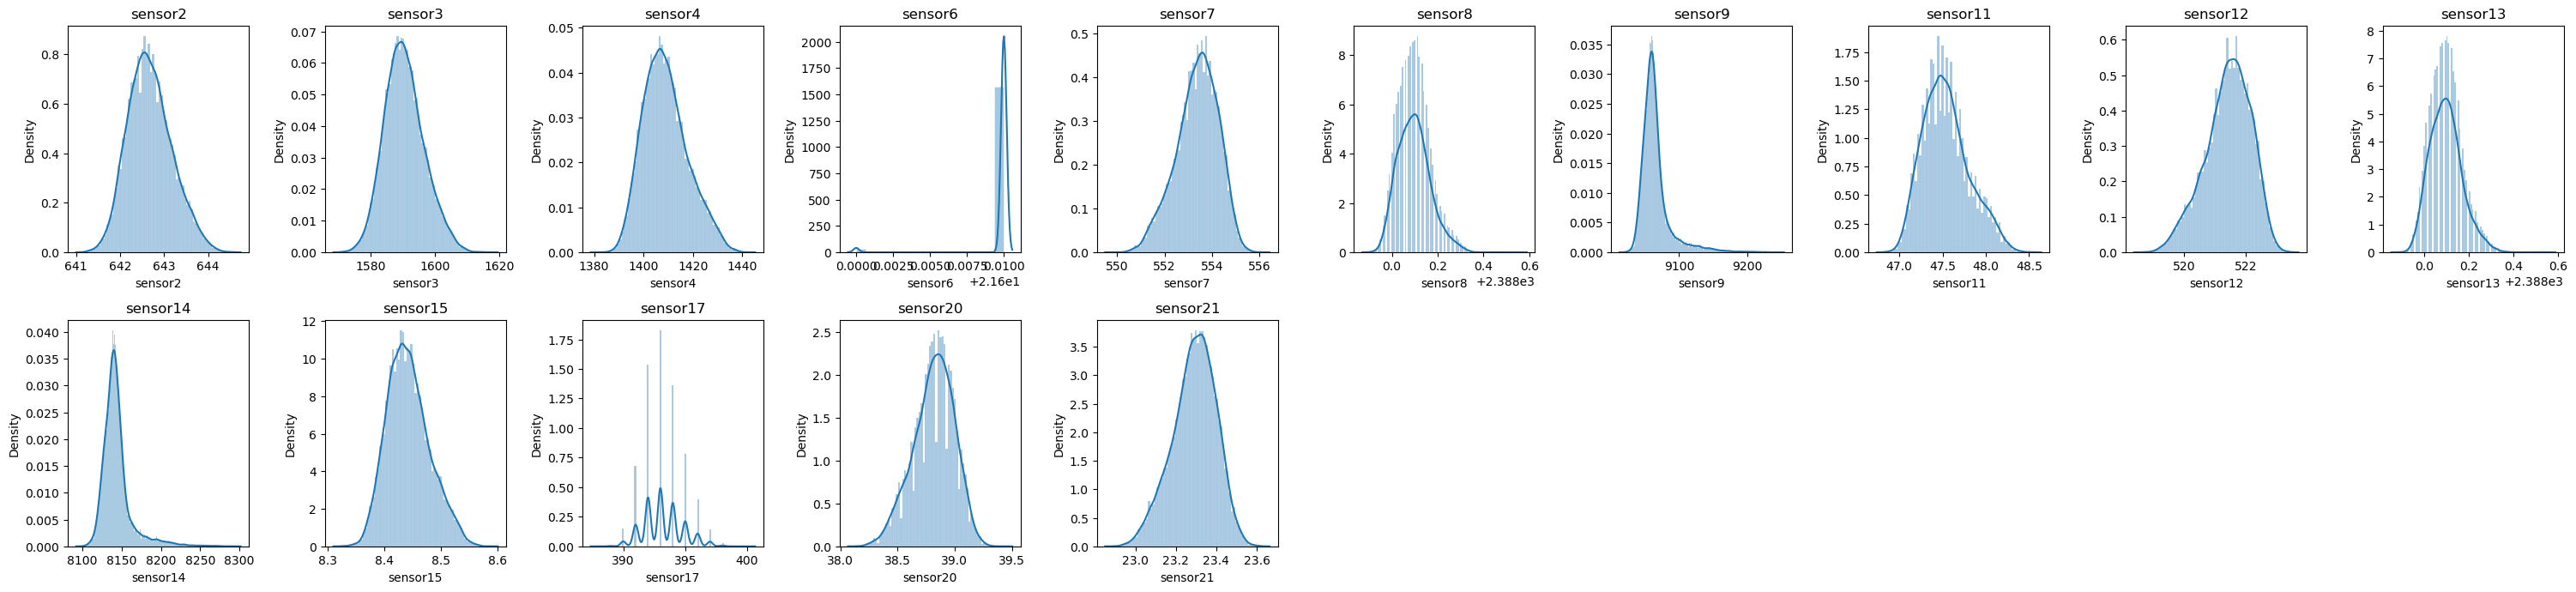

In [13]:
def plotSensorDensity(train_list,numeroDF, sensors):
    
    plt.figure(figsize=(30, 10))
    df = train_list[numeroDF]
    i = 0
    removable_sensors = []
    for sensor in sensors:
        
        if(len(df[sensor].unique()) <= 1):
            removable_sensors.append(sensor)
            continue

        plt.subplot(3, 10, i+1).set_title(sensor)
        sns.histplot(df[sensor], kde=True, stat = "density", kde_kws=dict(cut=3), 
        alpha=.4, edgecolor=(1, 1, 1, .4)) #ex distplot
        i+=1
    plt.tight_layout()
    return removable_sensors

removable_sensors = plotSensorDensity(train, 0, sensors)

Rimuoviamo quindi i seguenti sensori 
- Sensore 1
- Sensore 5
- Sensore 10
- Sensore 16
- Sensore 18
- Sensore 19

In [14]:
print(removable_sensors)

for df in train:
    df.drop(removable_sensors, inplace=True, axis=1)

train[0].head()

['sensor1', 'sensor5', 'sensor10', 'sensor16', 'sensor18', 'sensor19']


unit_number  time_cycle  op_setting1  op_setting2  op_setting3  sensor2  \
0            1           1      -0.0007      -0.0004        100.0   641.82   
1            1           2       0.0019      -0.0003        100.0   642.15   
2            1           3      -0.0043       0.0003        100.0   642.35   
3            1           4       0.0007       0.0000        100.0   642.35   
4            1           5      -0.0019      -0.0002        100.0   642.37   

   sensor3  sensor4  sensor6  sensor7  ...  sensor9  sensor11  sensor12  \
0  1589.70  1400.60    21.61   554.36  ...  9046.19     47.47    521.66   
1  1591.82  1403.14    21.61   553.75  ...  9044.07     47.49    522.28   
2  1587.99  1404.20    21.61   554.26  ...  9052.94     47.27    522.42   
3  1582.79  1401.87    21.61   554.45  ...  9049.48     47.13    522.86   
4  1582.85  1406.22    21.61   554.00  ...  9055.15     47.28    522.19   

   sensor13  sensor14  sensor15  sensor17  sensor20  sensor21    RUL  
0   2388.02   8138.62    8.4195       392     39.06   23.4190  191.0  
1   2388.07   8131.49    8.4318       392     39.00   23.4236  190.0  
2   2388.03   8133.23    8.4178       390     38.95   23.3442  189.0  
3   2388.08   8133.83    8.3682       392     38.88   23.3739  188.0  
4   2388.04   8133.80    8.4294       393     38.90   23.4044  187.0  

[5 rows x 21 columns]

In [15]:
#Rimuoviamo dalla lista i sesori che abbiamo indiciduato
for sensor in removable_sensors: 
    sensors.remove(sensor)
print(sensors)

['sensor2', 'sensor3', 'sensor4', 'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor17', 'sensor20', 'sensor21']


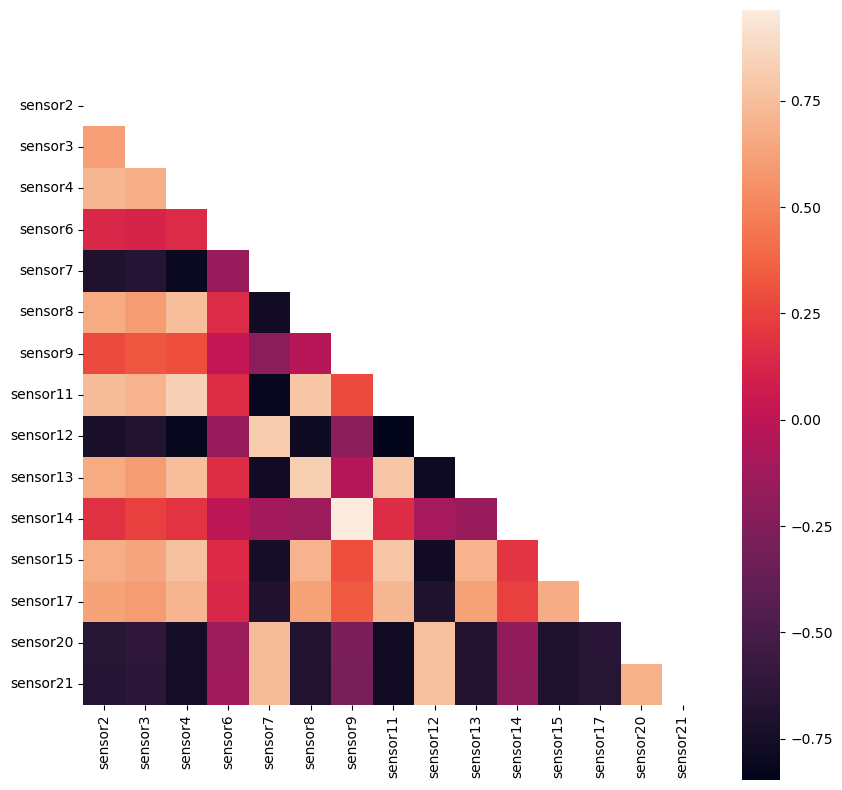

In [16]:
def plotSensorsCorrelation(train_list,numeroDF, sensors):
    df = train_list[numeroDF]
    correlation = df[sensors].corr()
    
#Queste due righe di codice servono per fare in modo di mostrare soltanto la parte bassa della matrice 
#Invece che la sua interezza dato che è simmetrica rispetto alla diagionale principale
    mask = np.zeros_like(correlation, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    
    plt.figure(figsize=(10, 10))
    sns.heatmap(correlation, square = True, mask = mask)

plotSensorsCorrelation(train, 0, sensors)

### Min Max scaling

Come da paper, applico il min max scaling 

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

In [18]:
all_columns = df.columns.tolist()
columns_to_keep = [item for item in all_columns if item not in sensors]
 
#Sensors è la nostra columns_to_scale

In [19]:
print(columns_to_keep)

['unit_number', 'time_cycle', 'op_setting1', 'op_setting2', 'op_setting3', 'RUL']


In [20]:
#Utilizziamo un trasformatore per decidere di quali colonne vogliamo fare lo scaling
def dataScaling(train, numeroDF, columns_to_keep, columns_to_scale):
    df = train[numeroDF]
    scaler = MinMaxScaler() 
    transformers = [
        ('scaled', scaler, columns_to_scale),
        ('unchanged', 'passthrough', columns_to_keep)
    ]
    ct = ColumnTransformer(transformers=transformers)
    scaled_data = ct.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale + columns_to_keep)

    return scaled_df

Importo i dati scalati all'interno di 4 nuovi dataframe all'interno di una lista unica chiamata *scaled_train*

In [21]:
scaled_train = []
for i in range(0,4): 
    scaled_df = dataScaling(train, i, columns_to_keep, sensors)
    scaled_df = scaled_df[columns_to_keep + sensors]
    scaled_train.append(scaled_df)

scaled_train[0].head()

unit_number  time_cycle  op_setting1  op_setting2  op_setting3    RUL  \
0          1.0         1.0      -0.0007      -0.0004        100.0  191.0   
1          1.0         2.0       0.0019      -0.0003        100.0  190.0   
2          1.0         3.0      -0.0043       0.0003        100.0  189.0   
3          1.0         4.0       0.0007       0.0000        100.0  188.0   
4          1.0         5.0      -0.0019      -0.0002        100.0  187.0   

    sensor2   sensor3   sensor4  sensor6  ...   sensor8   sensor9  sensor11  \
0  0.183735  0.406802  0.309757      1.0  ...  0.242424  0.109755  0.369048   
1  0.283133  0.453019  0.352633      1.0  ...  0.212121  0.100242  0.380952   
2  0.343373  0.369523  0.370527      1.0  ...  0.272727  0.140043  0.250000   
3  0.343373  0.256159  0.331195      1.0  ...  0.318182  0.124518  0.166667   
4  0.349398  0.257467  0.404625      1.0  ...  0.242424  0.149960  0.255952   

   sensor12  sensor13  sensor14  sensor15  sensor17  sensor20  sensor21  
0  0.633262  0.205882  0.199608  0.363986  0.333333  0.713178  0.724662  
1  0.765458  0.279412  0.162813  0.411312  0.333333  0.666667  0.731014  
2  0.795309  0.220588  0.171793  0.357445  0.166667  0.627907  0.621375  
3  0.889126  0.294118  0.174889  0.166603  0.333333  0.573643  0.662386  
4  0.746269  0.235294  0.174734  0.402078  0.416667  0.589147  0.704502  

[5 rows x 21 columns]

Procedo a controllare che la distribuzione dei dati sia rimasta invariata

[]

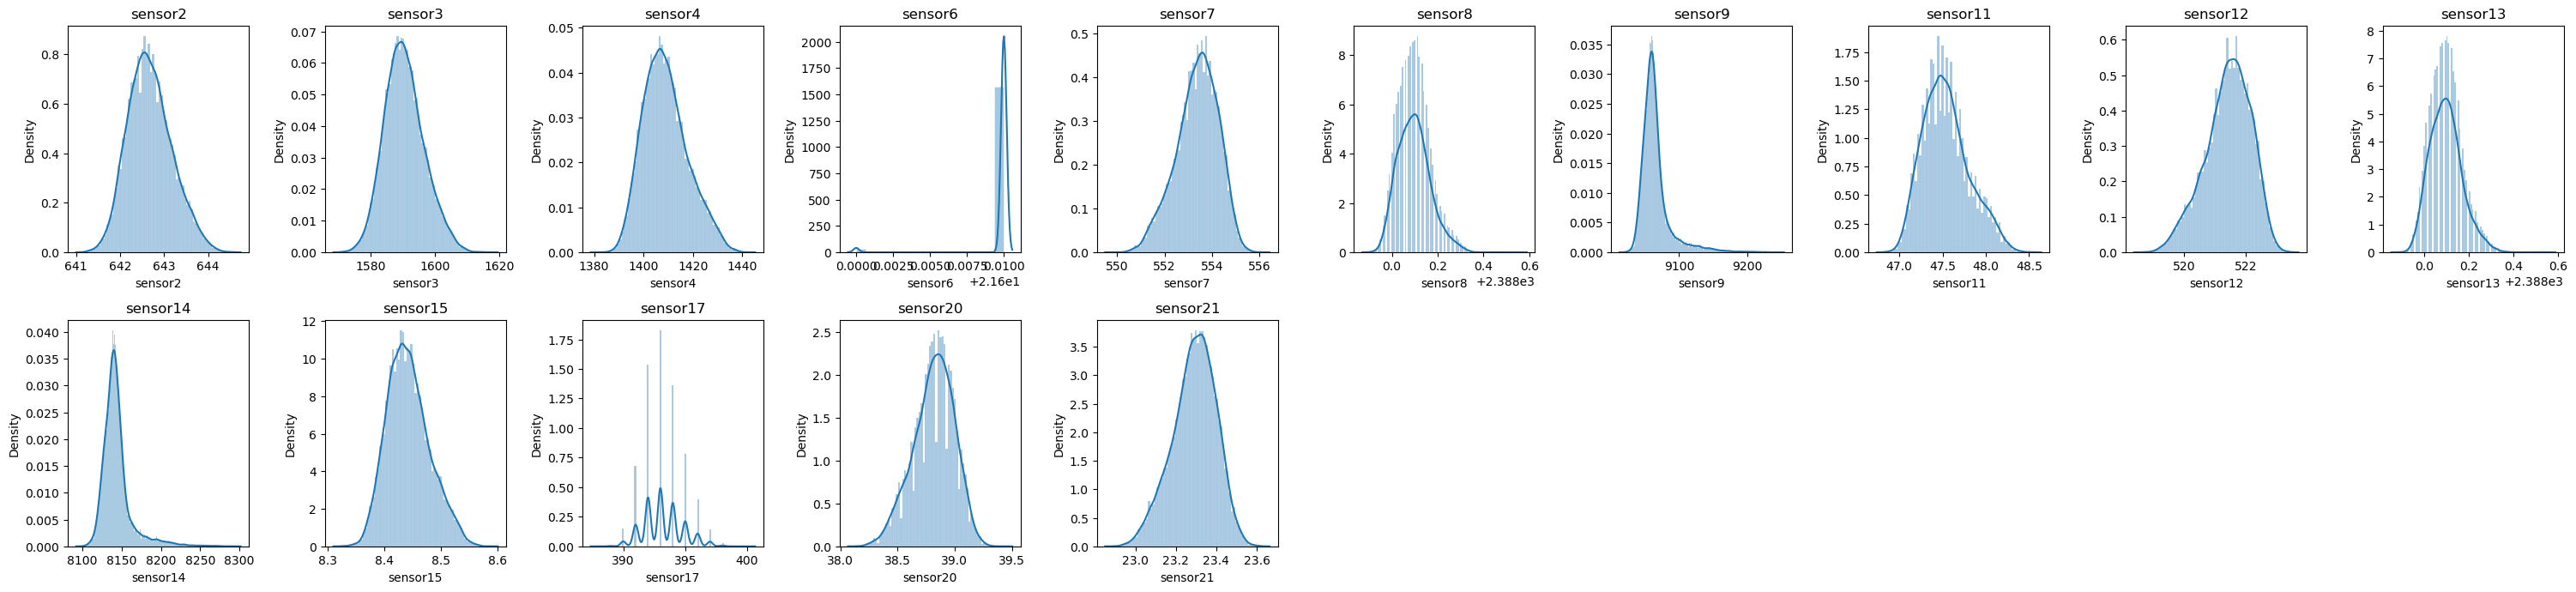

In [22]:
#Ripropongo il grafico precedente per un miglior confronto tra quest'ultimo 
#e la versione a cui è stato applicato il MinMaxScaler
plotSensorDensity(train, 0, sensors)

[]

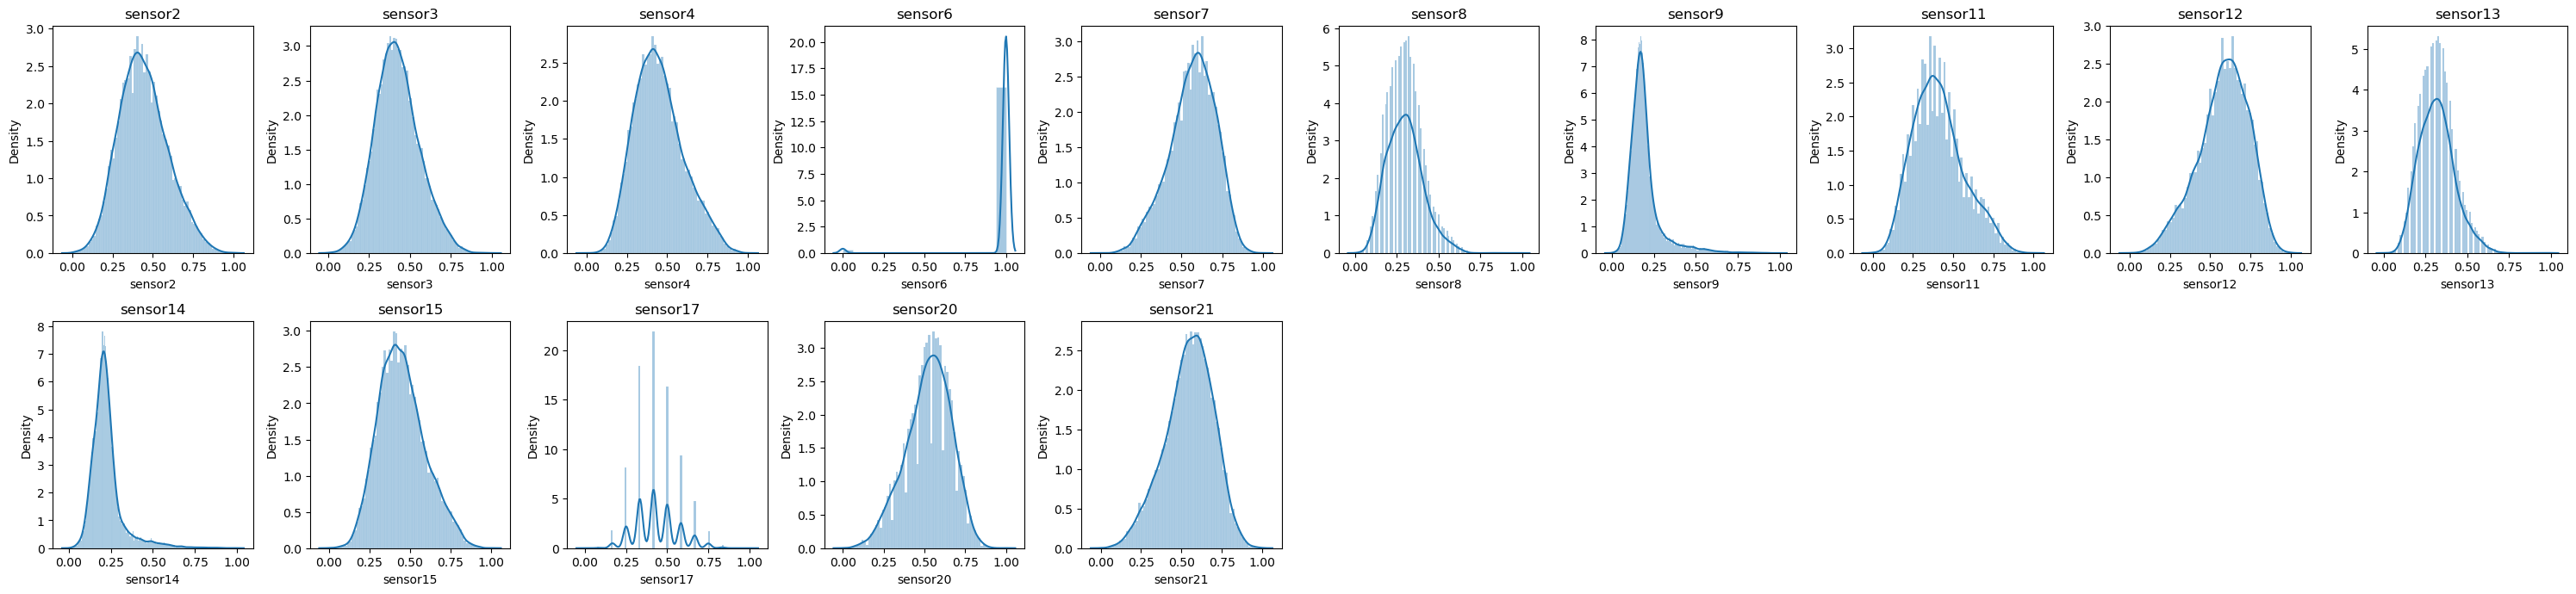

In [23]:
#Rimango abbastanza perplesso per quanto riguarda il ruolo del sensore 13 per quanto riguarda i dataframe in "Mixed Conditions"
#Non sembra dare un apporto significativo
plotSensorDensity(scaled_train,0, sensors)

le distribuzioni dei valori sono rimaste invariate, controlliamo adesso il plot effettivo dei valori dei sensori

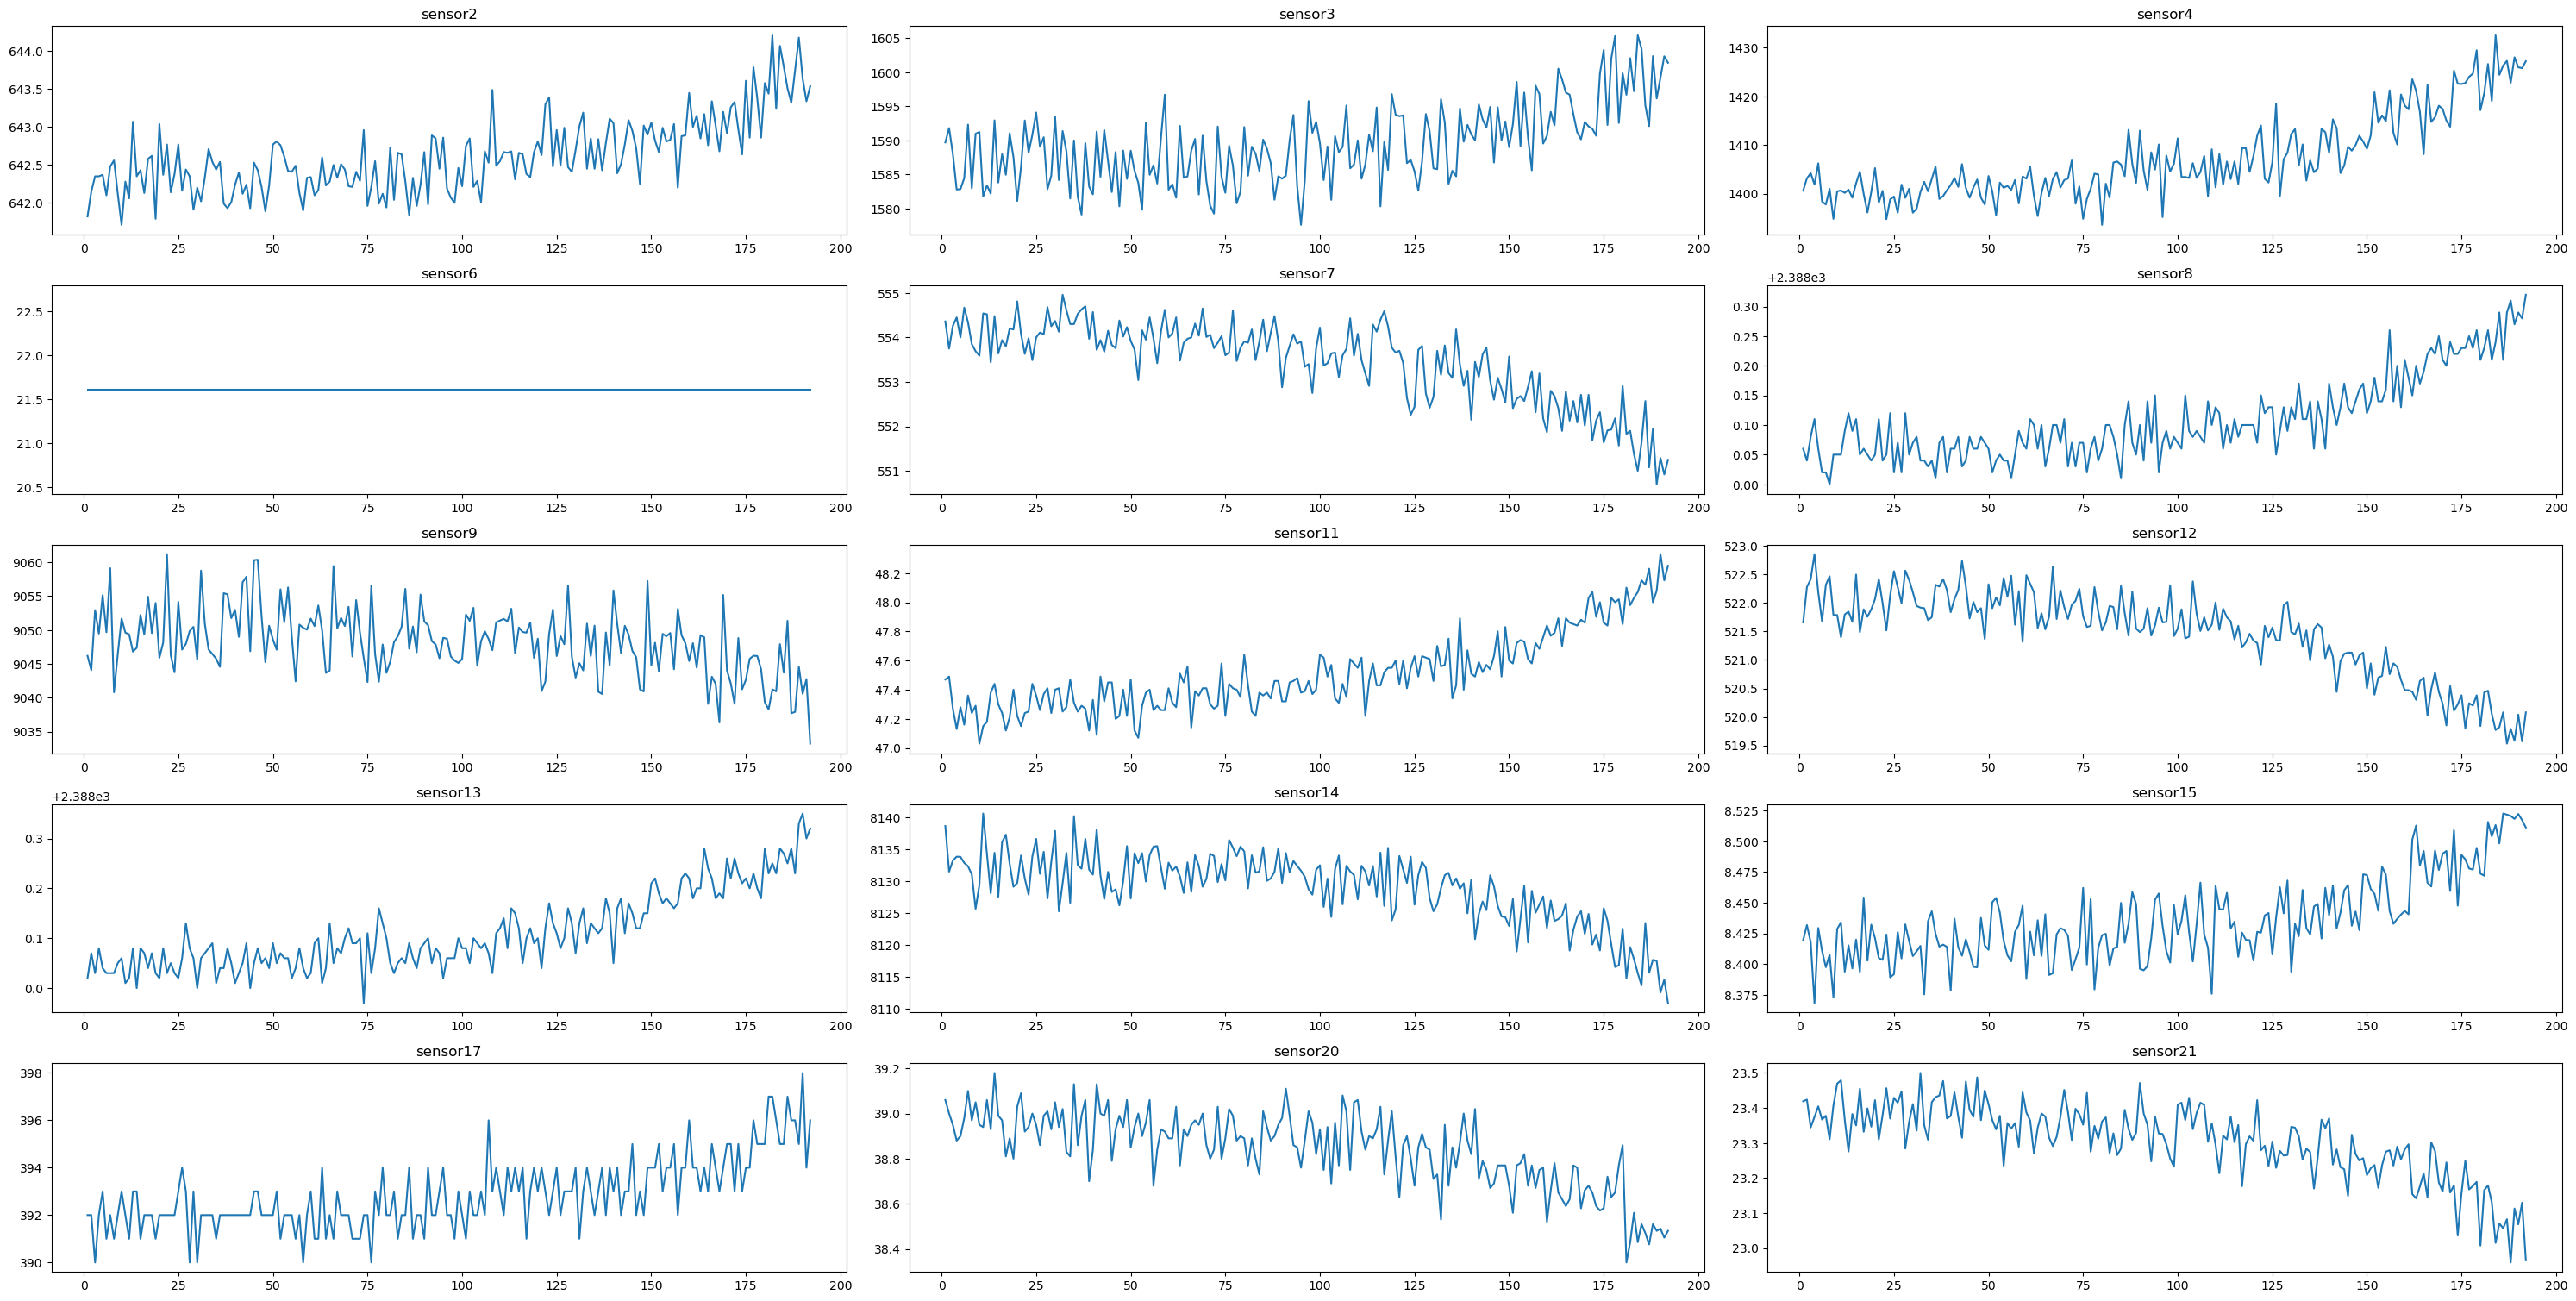

In [24]:
plotSensors(train, 0, 1, sensors)

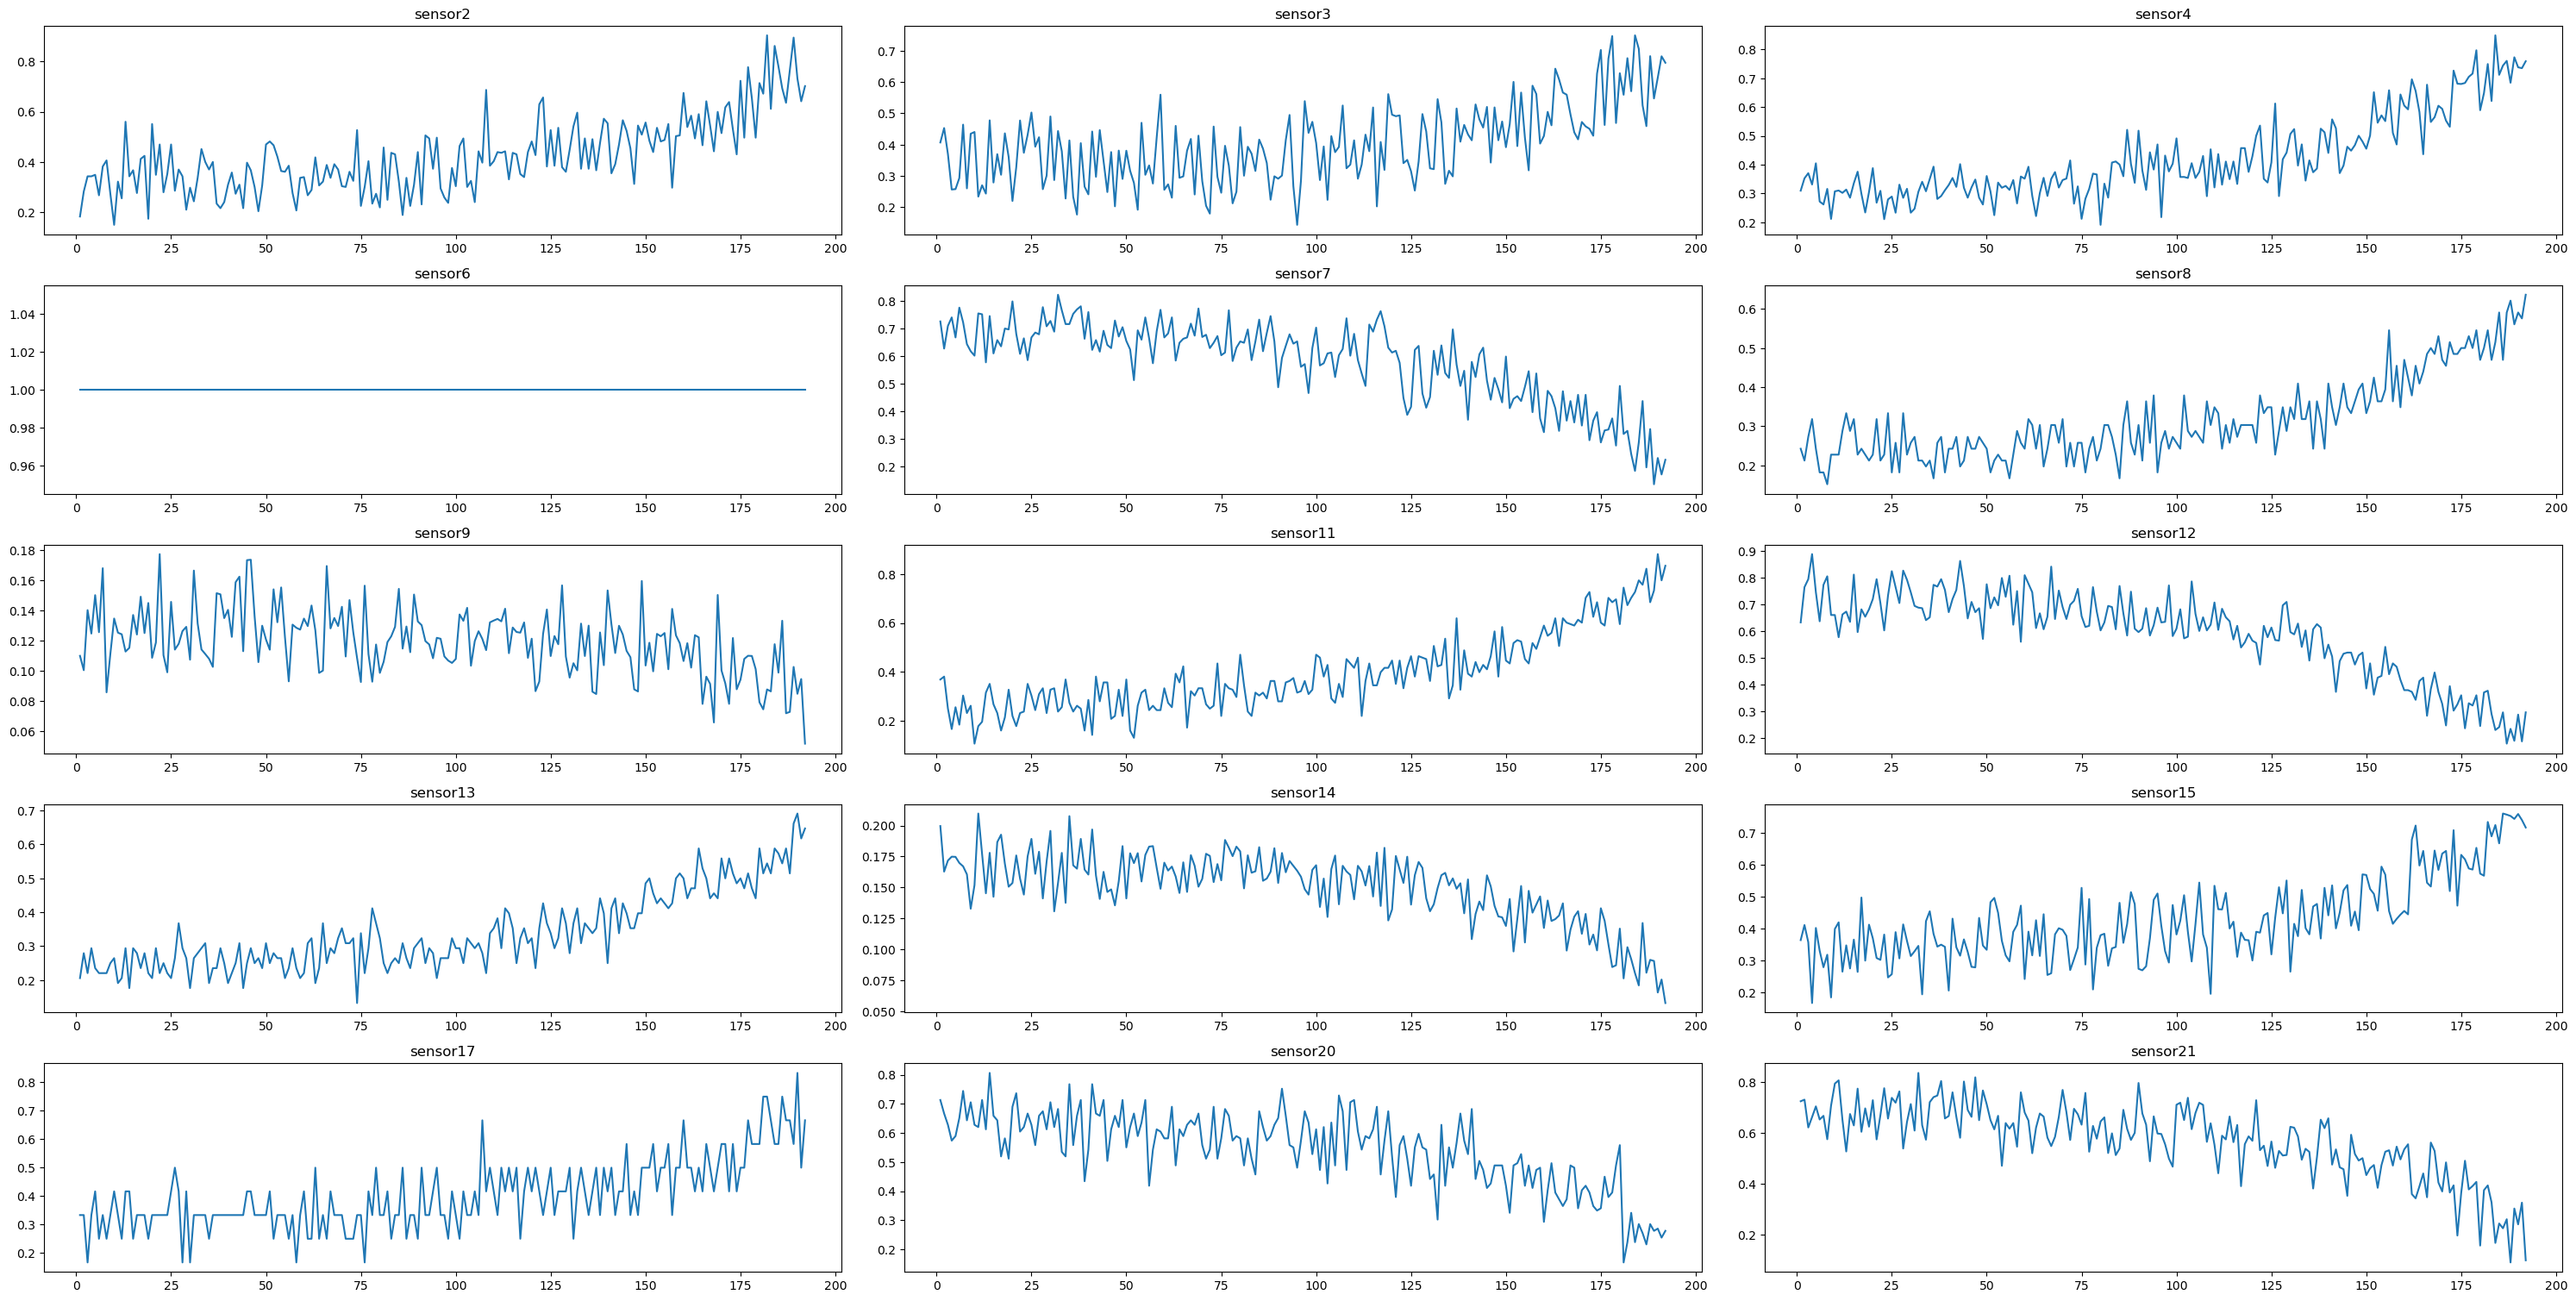

In [25]:
plotSensors(scaled_train, 0, 1, sensors)

#### Modelli e splitting del dataset

In [26]:
from sklearn.model_selection import train_test_split
import tensorflow as tf


train_df = pd.concat([scaled_train[0], scaled_train[1], scaled_train[2],scaled_train[3]], axis=0) #Concateno tutti i dataframe in un unico elemento
y = train_df['RUL'].values
X = train_df.drop('RUL', axis=1)

# X.head()

2023-09-09 11:39:03.221363: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-09 11:39:03.933160: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64:/home/aliquodfahriam/miniconda3/envs/tensorflowEnv/lib/
2023-09-09 11:39:03.933235: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/

### Preparazione dell'input per il layer LTSM
Il layer LTSM richiede un tensore che abbia 3 dimensioni, di base saremmo portati a dare in pasto alla rete direttamente il nostro dataset che avrebbe dimensione *(None, 19)*.

L'input richiesto da questo tipo di layer comprende 
- Campioni
- *Time Steps* 
- *Features* 

Nel paper hanno deciso di utilizzare un numero di 30 time steps e 14 features (escludendo quindi la parte che riguarda il *time cycle* ecc...)

In [27]:
print(scaled_train[0].dtypes)

unit_number    float64
time_cycle     float64
op_setting1    float64
op_setting2    float64
op_setting3    float64
RUL            float64
sensor2        float64
sensor3        float64
sensor4        float64
sensor6        float64
sensor7        float64
sensor8        float64
sensor9        float64
sensor11       float64
sensor12       float64
sensor13       float64
sensor14       float64
sensor15       float64
sensor17       float64
sensor20       float64
sensor21       float64
dtype: object


In [28]:
from keras.utils import pad_sequences
columns_to_keep = sensors
columns_to_keep.append('RUL')
selected_columns = train_df[sensors]
dataset_array = selected_columns.values

sequence_length = 30
sequences = [dataset_array[i:i+sequence_length] for i in range(len(dataset_array) - sequence_length + 1)]

sequences_padded = pad_sequences(sequences, maxlen=sequence_length, dtype='float32', padding='post')

X = sequences_padded[:, :, :-1]
y = sequences_padded[:, :, -1]


In [29]:
print(X.shape, y.shape)

(160330, 30, 15) (160330, 30)


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42) 

In [32]:
# X_train.drop('unit_number', axis=1, inplace=True)
# X_test.drop('unit_number', axis=1, inplace=True)
# X_train.head()
# X_test.head() 

### Metriche 
Definiamo come metriche il Root Mean Squared Error **(RMSE)**, ovvero la funzione di loss scelta dalla NASA, la quale ha reso pubblico il dataset e un *custom_score* per come è definito all'interno del paper di riferimento.

In particolare quest'ultimo risulta asimmetrica specialmente per quanto riguarda le predizioni tardive. Ad esse è infatti assegnata una penalità rispetto a quelle anticipate. Un basso punteggio significa una scarsa performance e viceversa. RMSE al contrario tende a dare egual peso sia alle predizioni anticipate che a quelle tardive. 

In [33]:
from keras import backend as K 
import math 
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 


# def custom_score(y_true, y_pred):
#      sum = 0 
#      for true, predicted in zip(y_true, y_pred): 
#           d_i = predicted - true
#           if d_i < 0:
#              esponente = 1/(d_i/13)
#              sum += (math.e ** esponente) -1 
#           else: 
#              esponente =  d_i/10
#              sum += (math.e ** esponente) -1 
     
#      return sum 

@tf.function
def custom_score2(y_true, y_pred):
    d_i = y_pred - y_true
    esponente = tf.where(d_i < 0, 1.0 / (d_i / 13.0), d_i / 10.0)
    sum = tf.reduce_sum(tf.exp(esponente) - 1.0)
    
    return sum


In [34]:
# from tensorflow.keras.metrics import Metric

# class CustomScore(Metric):
#     def __init__(self, name='custom_score', **kwargs):
#         super(CustomScore, self).__init__(name=name, **kwargs)
#         self.custom_score = self.add_weight(name='cs', initializer='zeros')

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         custom_score_value = custom_score(y_true, y_pred)
#         self.custom_score.assign_add(custom_score_value)

#     def result(self):
#         return self.custom_score


Genero i modelli per come sono espressi nel paper: 
- Small LSTM
    Composta da due layer LSTM, un layer di Flatten e 3 layer dense 
- Large LSTM
    Composta da quattro layer LSTM alternati a layers di dropout, un layer flatten e tre layer dense 

Usiamo come funzione di loss **root_mean_square_error** mentre **accuracy** e **custom_score** come metriche.

Custom score è definita come: 


$\begin{cases} \sum^{N}_{n=1} e^{\frac {-d_i} {13}} - 1   , & \text{if} \space \space d_i \lt 0 \\
\sum^{N}_{n=1} e^{\frac {d_i} {10}} - 1, &\text{otherwise} \space \space \end{cases} $  


In [35]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten

#Replica della rete neurale proposta come "small LSTM"
def createLSTMsmallModel(l1Nodes, l2Nodes, d1Nodes, d2Nodes, input_shape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=input_shape, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    
    lstm2 = LSTM(l2Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))    
    flatten = Flatten()
    dense1 = Dense(d1Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    dense2 = Dense(d2Nodes, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    # output layer
    outL = Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.1))
    
    #layers
    layers = [lstm1, lstm2,flatten,  dense1, dense2, outL]
    
    model = Sequential(layers)
    #Abbiamo aggiunto le nostre funzioni di loss e accuracy definite precedentemente
    model.compile(optimizer='adam', loss=root_mean_squared_error, metrics = ['accuracy', custom_score2] )
    return model


def createLSTMlargeModel(l1Nodes, l2Nodes, l3Nodes, l4Nodes, d1dense , d2dense, input_shape): 
    lstm1 = LSTM(l1Nodes, input_shape=input_shape, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d1 = Dropout(0.2)
    lstm2 = LSTM(l2Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d2 = Dropout(0.2)
    lstm3 = LSTM(l3Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d3 = Dropout(0.2)
    lstm4 = LSTM(l4Nodes, return_sequences=True, kernel_regularizer=regularizers.l2(0.1))
    d4 = Dropout(0.2)

    flatten = Flatten()

    dense1 = Dense(d1dense,activation='relu', kernel_regularizer=regularizers.l2(0.1))
    dense2 = Dense(d2dense,activation='relu', kernel_regularizer=regularizers.l2(0.1))
    output_dense = Dense(1,activation='relu', kernel_regularizer=regularizers.l2(0.1))

    layers = [lstm1,d1, lstm2,d2, lstm3, d3, lstm4, d4,flatten,  dense1, dense2, output_dense]

    model = Sequential(layers)
    model.compile(optimizer='adam', loss=root_mean_squared_error, metrics = ['accuracy', custom_score2])
    return model


In [36]:
LSTMlargeModel= createLSTMlargeModel(128, 64, 32, 16, 64, 32, (30,15))
LSTMsmallModel = createLSTMsmallModel(60, 30, 30, 15, (30, 15)) #0-14 sarebbe il numero dei sensori disponibili e 30 sarebbe il massimo di dati in input

2023-09-09 11:39:07.518358: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-09 11:39:07.518400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2023-09-09 11:39:07.519770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
LSTMsmallModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 60)            18240     
                                                                 
 lstm_5 (LSTM)               (None, 30, 30)            10920     
                                                                 
 flatten_1 (Flatten)         (None, 900)               0         
                                                                 
 dense_3 (Dense)             (None, 30)                27030     
                                                                 
 dense_4 (Dense)             (None, 15)                465       
                                                                 
 dense_5 (Dense)             (None, 1)                 16        
                                                                 
Total params: 56,671
Trainable params: 56,671
Non-trai

In [38]:
LSTMlargeModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           73728     
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 32)            12416     
                                                                 
 dropout_2 (Dropout)         (None, 30, 32)            0         
                                                                 
 lstm_3 (LSTM)               (None, 30, 16)            3

In [39]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model, save_model

EPOCHS = 100

path_small = './models/LSTMsmall'
path_large = './models/LSTMlarge'


model_checkpoint = ModelCheckpoint(
    path_small,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',

)


early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)



In [40]:
tf.shape(X_train)


<tf.Tensor: shape=(3,), dtype=int32, numpy=array([128264,     30,     15], dtype=int32)>

In [41]:
X_train.shape

(128264, 30, 15)

In [42]:
history_small = LSTMsmallModel.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs = EPOCHS,
    batch_size = 32,
    use_multiprocessing =True, 
    callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
 889/4009 [=====>........................] - ETA: 1:07 - loss: 91.2090 - accuracy: 0.0045 - custom_score2: 8011525.0000

KeyboardInterrupt: 

In [ ]:
model_checkpoint = ModelCheckpoint(
    path_large,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',

)
history_large = LSTMlargeModel.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs = EPOCHS,
    batch_size = 32,
    use_multiprocessing =True, 
    callbacks=[model_checkpoint, early_stopping])